In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('/content/Mall_Customers (1).csv')

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.drop(columns=['CustomerID'], inplace=True)

df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [5]:
df.sample(5)

,Gender,Age,Annual Income (k$),Spending Score (1-100)
56,Female,51,44,50
127,Male,40,71,95
71,Female,47,49,42
140,Female,57,75,5
187,Male,28,101,68


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [7]:
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


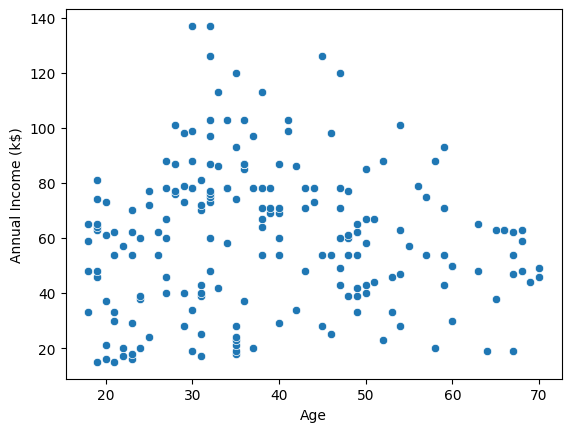

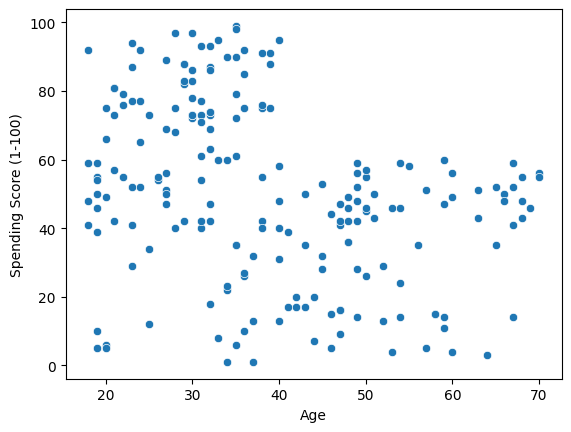

In [8]:
sns.scatterplot(x='Age', y='Annual Income (k$)', data=df)
plt.show()

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=df)
plt.show()

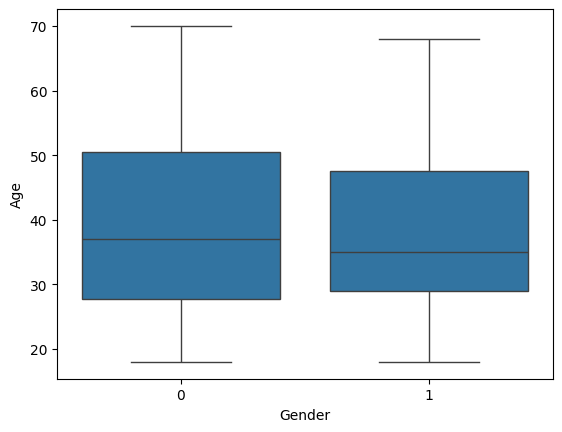

In [9]:
sns.boxplot(x='Gender', y='Age', data=df)
plt.show()

In [10]:
scaler = MinMaxScaler()
df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] = scaler.fit_transform(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,0.019231,0.000000,0.387755
1,0,0.057692,0.000000,0.816327
2,1,0.038462,0.008197,0.051020
3,1,0.096154,0.008197,0.775510
4,1,0.250000,0.016393,0.397959


In [11]:
knn = NearestNeighbors(n_neighbors=6)
nbrs = knn.fit(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
distances, indices = nbrs.kneighbors(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])


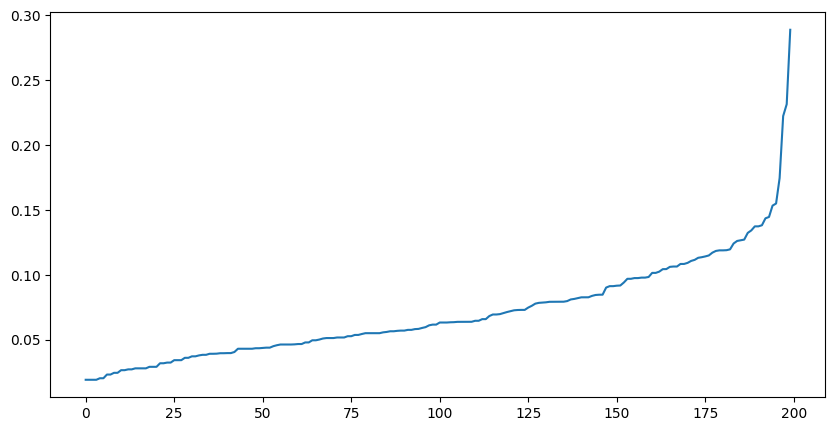

In [12]:
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.show()

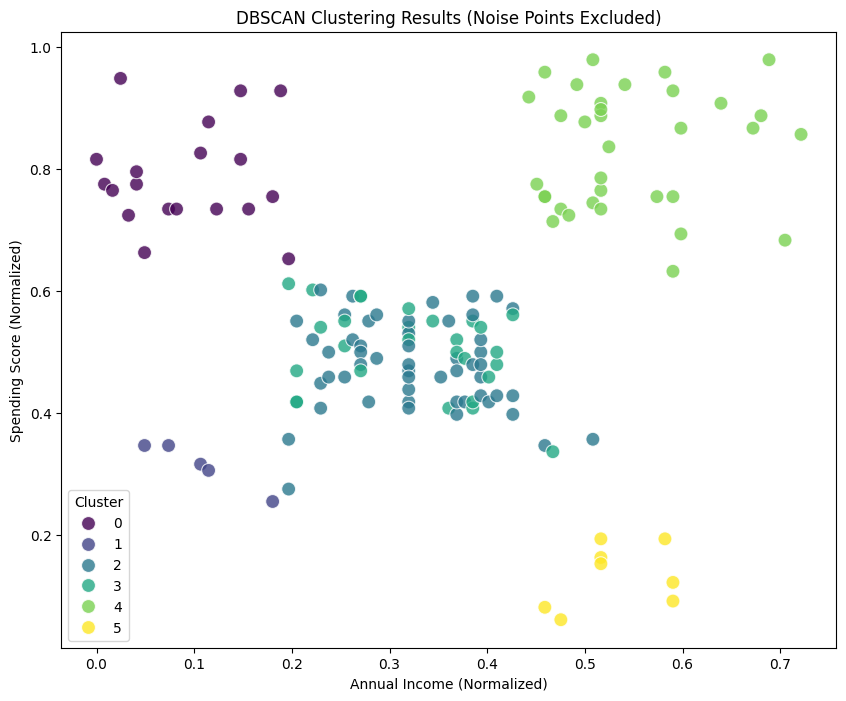

In [13]:
dbscan = DBSCAN(eps=0.13, min_samples=5, metric='euclidean')

df['cluster'] = dbscan.fit_predict(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
df_filtered = df[df['cluster'] != -1]

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    data=df_filtered,
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='cluster',
    palette='viridis',
    s=100,
    alpha=0.8
)

plt.title('DBSCAN Clustering Results (Noise Points Excluded)')
plt.xlabel('Annual Income (Normalized)')
plt.ylabel('Spending Score (Normalized)')
plt.legend(title='Cluster')
plt.show()

In [14]:
sil_score = silhouette_score(df, df['cluster'])
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.4813121711055937


In [15]:
eps_values = [0.1, 0.12, 0.13, 0.15, 0.2]
min_samples_values = [3, 5, 7, 10]

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        labels = dbscan.fit_predict(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

        if len(set(labels)) - (1 if -1 in labels else 0) >= 2:
            mask = labels != -1
            if sum(mask) > 1:
                sil_score = silhouette_score(
                    df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']][mask],
                    labels[mask]
                )
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                n_noise = list(labels).count(-1)

                results.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'silhouette_score': sil_score,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'n_noise_percent': n_noise / len(labels) * 100
                })
        else:
            print(f"Skipping eps={eps}, min_samples={min_samples}: Not enough clusters formed")

results_df = pd.DataFrame(results)
if not results_df.empty:
    results_df = results_df.sort_values('silhouette_score', ascending=False)
    print("Top 5 parameter combinations by silhouette score:")
    print(results_df.head())
else:
    print("No valid parameter combinations found")

Skipping eps=0.2, min_samples=3: Not enough clusters formed
Skipping eps=0.2, min_samples=5: Not enough clusters formed
Skipping eps=0.2, min_samples=7: Not enough clusters formed
Skipping eps=0.2, min_samples=10: Not enough clusters formed
Top 5 parameter combinations by silhouette score:
     eps  min_samples  silhouette_score  n_clusters  n_noise  n_noise_percent
3   0.10           10          0.805451           2      174             87.0
7   0.12           10          0.667178           3      130             65.0
11  0.13           10          0.570390           5       87             43.5
2   0.10            7          0.566721           5      130             65.0
6   0.12            7          0.538806           5       86             43.0


Silhouette Score: 0.5570
Number of clusters: 4
Number of noise points: 75 (37.50%)


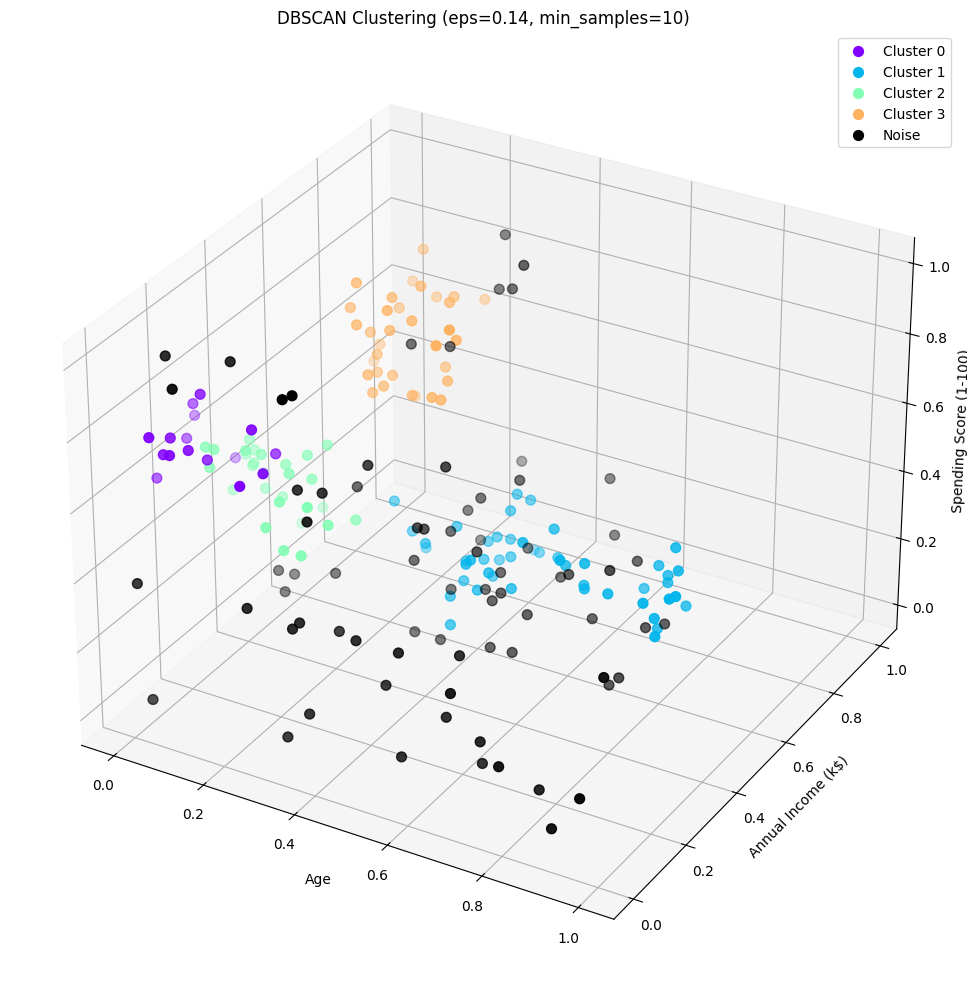

In [16]:
eps = 0.14
min_samples = 10
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
labels = dbscan.fit_predict(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

if len(set(labels)) - (1 if -1 in labels else 0) >= 2:
    mask = labels != -1
    if sum(mask) > 1:
        sil_score = silhouette_score(
            df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']][mask],
            labels[mask]
        )
        print(f"Silhouette Score: {sil_score:.4f}")

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        print(f"Number of clusters: {n_clusters}")
        print(f"Number of noise points: {n_noise} ({n_noise / len(labels):.2%})")

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

unique_labels = set(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        color = [0, 0, 0, 1]

    mask = labels == label
    ax.scatter(
        df['Age'][mask],
        df['Annual Income (k$)'][mask],
        df['Spending Score (1-100)'][mask],
        c=[color],
        label=f'Cluster {label}' if label != -1 else 'Noise',
        s=50
    )

ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
plt.legend()
plt.tight_layout()
plt.show()